In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import plotly 
from plotly.offline   import iplot,init_notebook_mode
import plotly.graph_objs as go
import plotly.express as px
import cufflinks as cf
from cufflinks.offline import go_offline
import folium
from folium.plugins import HeatMap

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import max_error,mean_absolute_error,median_absolute_error,r2_score,mean_squared_log_error

import warnings

warnings.filterwarnings('ignore')
init_notebook_mode(connected = True)
go_offline(connected=True)
basemap=folium.Map()
colors = px.colors.qualitative.Prism



In [3]:
# Importando os dados
df = pd.read_csv('best_region.csv').reset_index().drop(['id','date','index','Unnamed: 0'],axis=1)
y = df['price'].values

df.shape

(553, 19)

In [7]:
# Convertando features para o tipo correto(de float para int)
df['bathrooms'] = pd.DataFrame(df['bathrooms'],columns=['bathrooms']).astype(int)
df['floors'] = pd.DataFrame(df['floors'],columns=['floors']).astype(int)

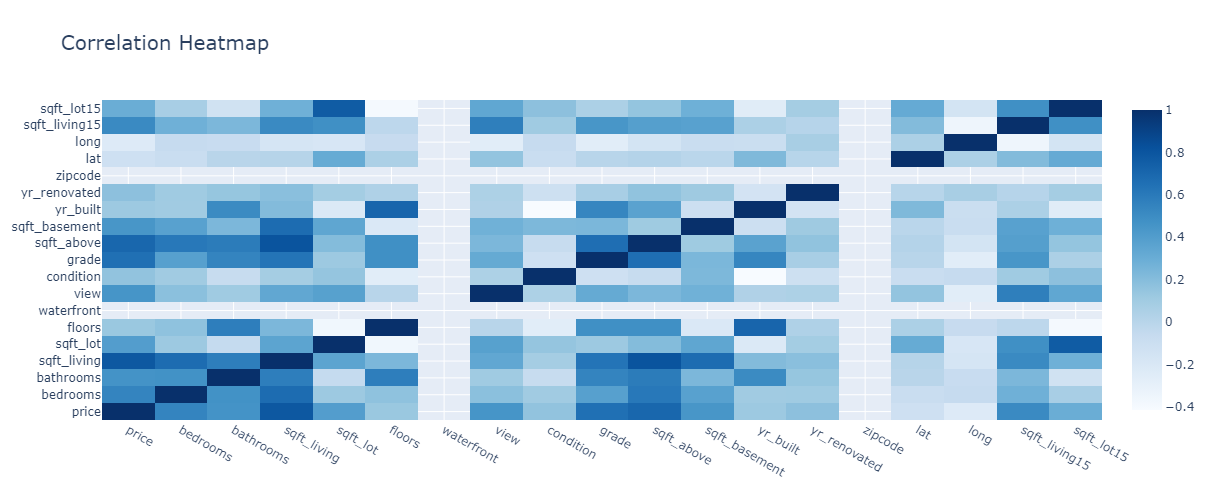

In [8]:
# Mapa de correlação
corr = df.corr()
corr.iplot(kind='heatmap',colorscale='Blues',hoverinfo='all',
           layout = go.Layout(title='Correlation Heatmap',titlefont=dict(size=20),autosize = False ,width = 700,height=500))

In [9]:
# Features com |corr| < 0.15
bad_ft =['condition','yr_built','yr_renovated','zipcode','long','lat','waterfront']

In [10]:
ndf = df.drop(bad_ft,axis=1)

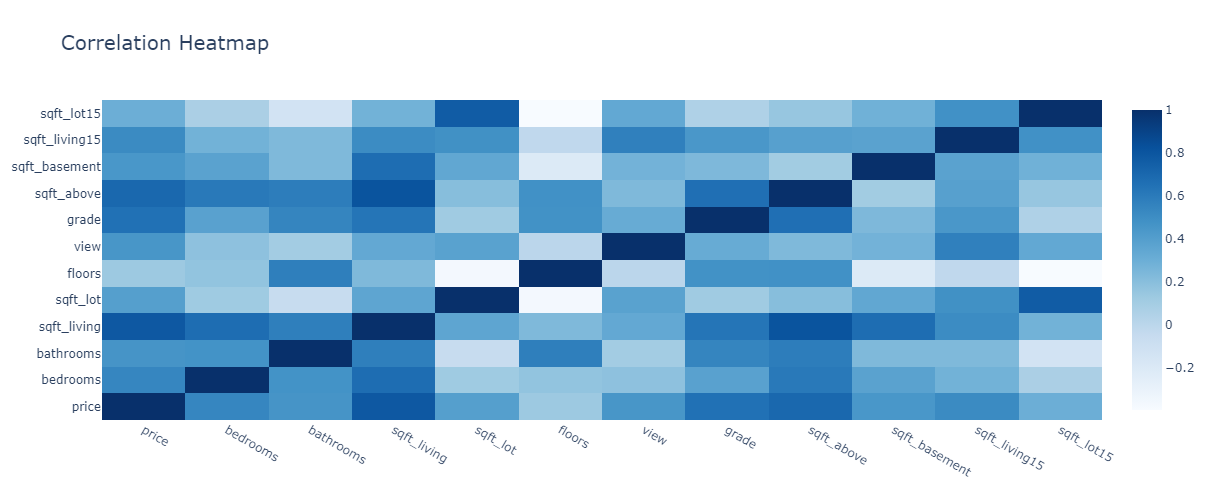

In [11]:
# Mapa de correlação
corr = ndf.corr()
corr.iplot(kind='heatmap',colorscale='Blues',hoverinfo='all',
           layout = go.Layout(title='Correlation Heatmap',titlefont=dict(size=20),autosize = False ,width = 800,height=500))

In [12]:
# Dropando as features com uma alta multicolinearidade
n2df = ndf.drop(['bedrooms','bathrooms','sqft_living15','sqft_above','sqft_lot15','view','floors'],axis=1)
n2df.head(3)

,price,sqft_living,sqft_lot,grade,sqft_basement
0,687500.0,2330,5000,7,820
1,535000.0,1090,3000,8,0
2,600000.0,1410,4080,7,410


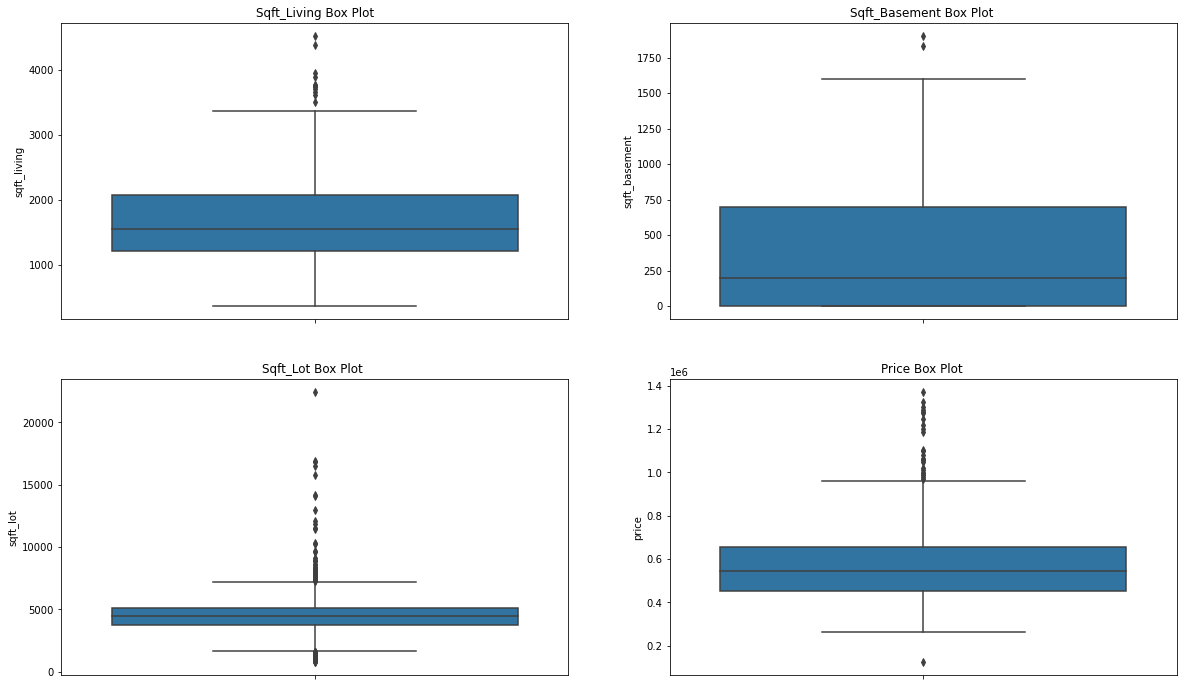

In [21]:
# Analisando os Outliers
plt.figure(figsize=(20,12))
plt.subplot(2,2,1)
sns.boxplot(y='sqft_living',data=n2df)
plt.title('Sqft_Living Box Plot')

plt.subplot(2,2,2)
sns.boxplot(y='sqft_basement',data=n2df)
plt.title('Sqft_Basement Box Plot ')

plt.subplot(2,2,3)
sns.boxplot(y='sqft_lot',data=n2df)
plt.title('Sqft_Lot Box Plot ')

plt.subplot(2,2,4)
sns.boxplot(y='price',data=n2df)
plt.title('Price Box Plot ')
plt.show()


In [14]:
# Encontrando os OutLiters em sqft_living, e construindo um TrashHold
sqft_liv= n2df['sqft_living']

q25,q75 = np.percentile(sqft_liv,25),np.percentile(sqft_liv,75)
print(f'q25 = {q25}, q75 = {q75}')

liv_iqr = q75-q25
print(f'iqr = {liv_iqr}')

liv_cutoff = liv_iqr*1.95
liv_upper = (q75+liv_cutoff)
print(f'Cut Off = {liv_cutoff}')
print(f'Sqft_Living Upper = {liv_upper}')

outliers = [x for x in sqft_liv if x >liv_upper]
print(f'Feature Sqft_Living Outliers {len(outliers)}')  

q25 = 1220.0, q75 = 2080.0
iqr = 860.0
Cut Off = 1677.0
Sqft_Living Upper = 3757.0
Feature Sqft_Living Outliers 6


In [15]:
# Encontrando os OutLiters em sqft_basement, e construindo um TrashHold
sqft_base= n2df['sqft_basement']

q25,q75 = np.percentile(sqft_base,25),np.percentile(sqft_base,75)
print(f'q25 = {q25}, q75 = {q75}')

base_iqr = q75-q25
print(f'iqr = {base_iqr}')

base_cutoff = base_iqr*1.2
base_upper = (q75+base_cutoff)
print(f'Cut Off = {base_cutoff}')
print(f'Sqft_Basement Upper = {base_upper}')

outliers = [x for x in sqft_base if x >base_upper]
print(f'Feature Sqft_Basement Outliers {len(outliers)}')

q25 = 0.0, q75 = 700.0
iqr = 700.0
Cut Off = 840.0
Sqft_Basement Upper = 1540.0
Feature Sqft_Basement Outliers 3


In [16]:
# Encontrando os OutLiters em sqft_lot, e construindo um TrashHold
sqft_lot= n2df['sqft_lot']

q25,q75 = np.percentile(sqft_lot,25),np.percentile(sqft_lot,75)
print(f'q25 = {q25}, q75 = {q75}')

lot_iqr = q75-q25
print(f'iqr = {lot_iqr}')

lot_cutoff = lot_iqr*6
lot_cutoff_lower = lot_iqr*1
lot_upper = (q75+lot_cutoff)
lot_lower = (q25-lot_cutoff_lower)
print(f'Cut Off = {lot_cutoff}')
print(f'Sqft_Lot Upper = {lot_upper}')
print(f'Sqft_Lot Lower = {lot_lower}')


outliers = [x for x in sqft_lot if x >lot_upper or x < lot_lower]
print(f'Feature Sqft_Basement Outliers {len(outliers)}')

q25 = 3740.0, q75 = 5150.0
iqr = 1410.0
Cut Off = 8460.0
Sqft_Lot Upper = 13610.0
Sqft_Lot Lower = 2330.0
Feature Sqft_Basement Outliers 71


In [17]:
# Encontrando os OutLiters em price, e construindo um TrashHold
prices= n2df['price']

q25,q75 = np.percentile(prices,25),np.percentile(prices,75)
print(f'q25 = {q25}, q75 = {q75}')

price_iqr = q75-q25
print(f'iqr = {price_iqr}')

price_cutoff = price_iqr*2.6
price_cutoff_lower = price_iqr*1.2

price_upper = (q75+price_cutoff)
price_lower = (q25-price_cutoff_lower)
print(f'Cut Off = {price_cutoff}')
print(f'Price Upper = {price_upper}')
print(f'Price LOWER = {price_lower}')

outliers = [x for x in prices if x >price_upper or x < price_lower]
print(f'Price Outliers {len(outliers)}')

q25 = 450000.0, q75 = 657500.0
iqr = 207500.0
Cut Off = 539500.0
Price Upper = 1197000.0
Price LOWER = 201000.0
Price Outliers 10


In [18]:
# Removendo os outliers do conjunto de dados
cut_out_prices =  n2df.drop(n2df[(n2df['price'] > price_upper) | (n2df['price'] < price_lower) ].index)

cut_outl_living = cut_out_prices.drop(cut_out_prices[(cut_out_prices['sqft_living'] > liv_upper)].index)

cut_out_basement = cut_outl_living.drop(cut_outl_living[(cut_outl_living['sqft_basement'] > base_upper)].index)

cut_out_lot = cut_out_basement.drop(cut_out_basement[(cut_out_basement['sqft_lot'] > lot_upper) | (cut_out_basement['sqft_lot'] < lot_lower) ].index)



new_df = cut_out_lot

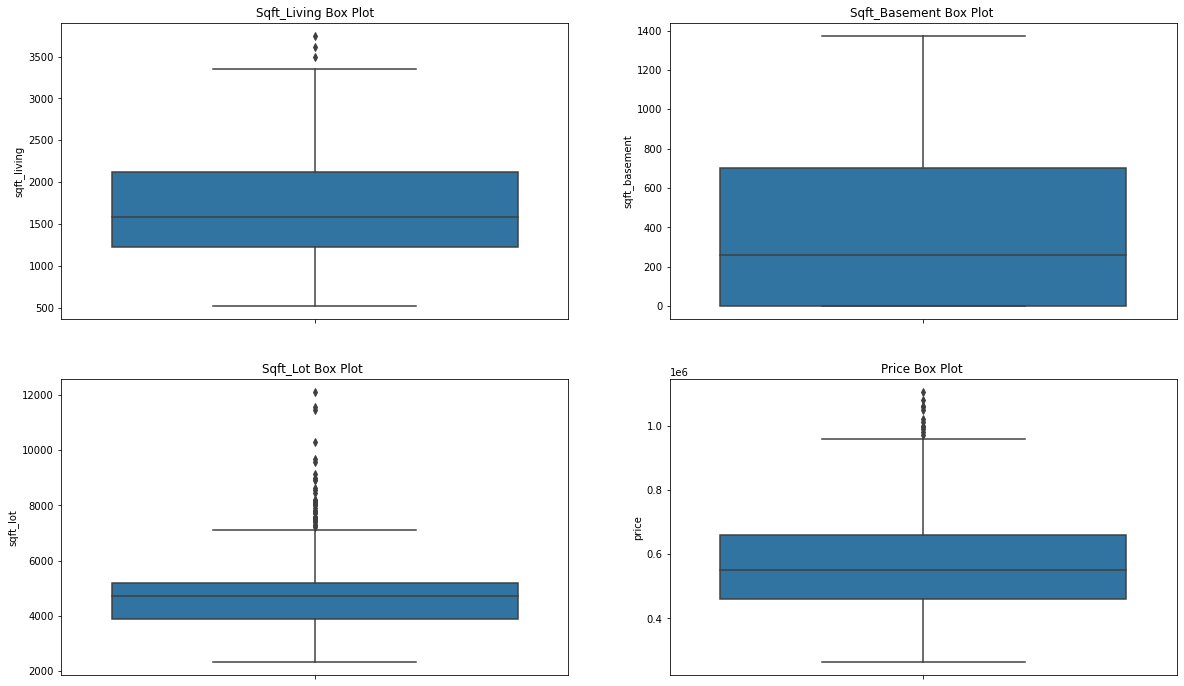

In [22]:
plt.figure(figsize=(20,12))
plt.subplot(2,2,1)
sns.boxplot(y='sqft_living',data=new_df)
plt.title('Sqft_Living Box Plot')

plt.subplot(2,2,2)
sns.boxplot(y='sqft_basement',data=new_df)
plt.title('Sqft_Basement Box Plot ')

plt.subplot(2,2,3)
sns.boxplot(y='sqft_lot',data=new_df)
plt.title('Sqft_Lot Box Plot ')

plt.subplot(2,2,4)
sns.boxplot(y='price',data=new_df)
plt.title('Price Box Plot ')
plt.show()

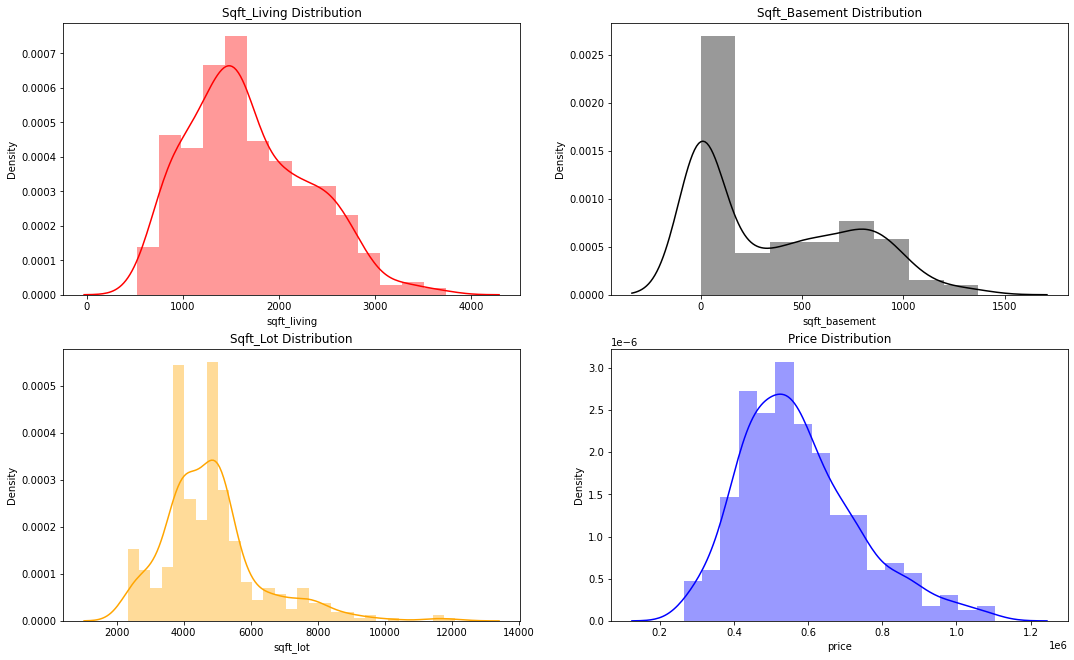

In [20]:
# Analisando a distribuição das features selecionadas e dos valores de price
plt.figure(figsize=(18,11))
plt.subplot(2,2,1)
sns.distplot(new_df['sqft_living'],color ='Red')
plt.title('Sqft_Living Distribution')

plt.subplot(2,2,2)
sns.distplot(new_df['sqft_basement'],color='black')
plt.title('Sqft_Basement Distribution')

plt.subplot(2,2,3)
sns.distplot(new_df['sqft_lot'],color='orange')
plt.title('Sqft_Lot Distribution')

plt.subplot(2,2,4)
sns.distplot(new_df['price'],color = 'blue')
plt.title('Price Distribution')
plt.show()

In [366]:
# Fazendo a normalização das features
from scipy import stats

living = new_df['sqft_living'].values
n_living = (stats.rankdata(living)/(len(living)+1)-0.5)*2
n_living = (np.arctanh(n_living) + np.max(np.arctanh(n_living)) + 0.01)
new_df['sqft_living'] = n_living

basement = new_df['sqft_basement'].values
n_basement = (stats.rankdata(basement)/(len(basement)+1)-0.5)
n_basement = (np.arctanh(n_basement) + np.max(np.arctanh(n_basement)) + 0.01)
new_df['sqft_basement'] = n_basement

lot = new_df['sqft_lot'].values
n_lot = (stats.rankdata(lot)/(len(lot)+1)-0.5)*2
n_lot = (np.arctanh(n_lot) + np.max(np.arctanh(n_lot)) + 0.01)
new_df['sqft_blot'] = n_lot

price = new_df['price'].values
n_price = (stats.rankdata(price)/(len(price)+1)-0.5)*2
n_price = (np.arctanh(n_price) + np.max(np.arctanh(n_price)) + 0.01)



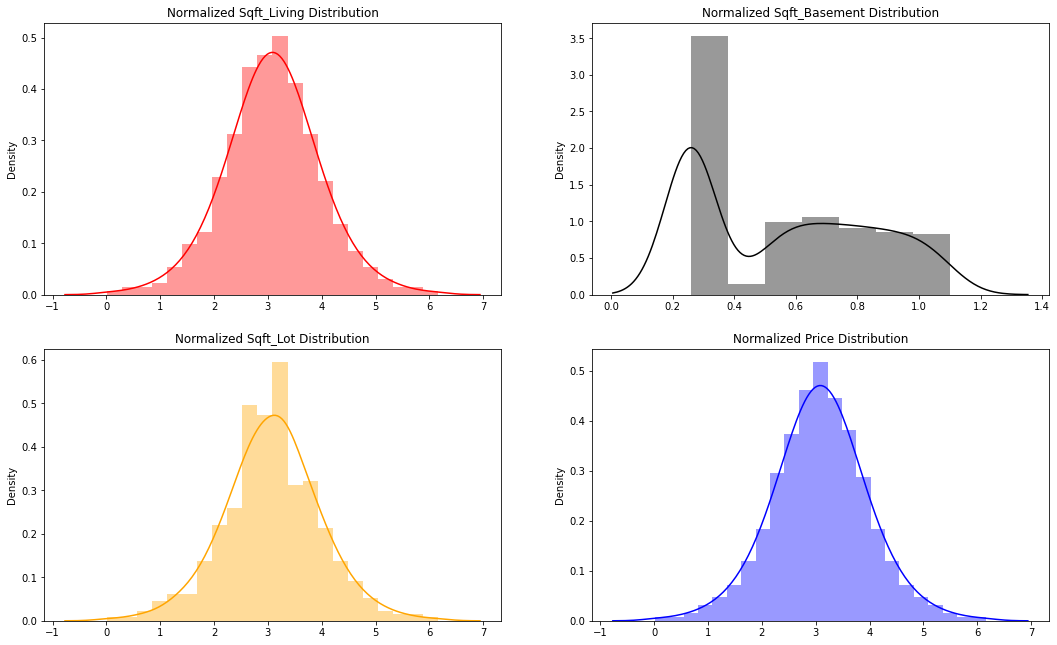

In [367]:
# Plotando as novas distribuições dos dados
plt.figure(figsize=(18,11))
plt.subplot(2,2,1)
sns.distplot(n_living,color ='Red')
plt.title('Normalized Sqft_Living Distribution')

plt.subplot(2,2,2)
sns.distplot(n_basement,color='black')
plt.title('Normalized Sqft_Basement Distribution')

plt.subplot(2,2,3)
sns.distplot(n_lot,color='orange')
plt.title('Normalized Sqft_Lot Distribution')

plt.subplot(2,2,4)
sns.distplot(n_price,color = 'blue')
plt.title('Normalized Price Distribution')
plt.show()

In [368]:
new_df.to_csv('processed_data.csv')